In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
IMG_H = 64
IMG_W = 64
IMG_C = 3  ## Change this to 1 for grayscale.

# Weight initializers for the Generator network
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
AUTOTUNE = tf.data.AUTOTUNE
    
learning_rate = 0.0001
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 100
eval_iters = 1
inner_iters = 10

eval_interval = 1
train_shots = 20
shots = 10
classes = 10

name_model = "prototype_one_few_shot"
g_model_path = "saved_model/g_"+name_model+"_"+str(meta_iters)+".h5"
d_model_path = "saved_model/d_"+name_model+"_"+str(meta_iters)+".h5"

In [3]:
# class for SSIM loss function
class SSIMLoss(tf.keras.losses.Loss):
    def __init__(self,
         reduction=tf.keras.losses.Reduction.AUTO,
         name='SSIMLoss'):
        super().__init__(reduction=reduction, name=name)

    def call(self, ori, recon):
        recon = tf.convert_to_tensor(recon)
        ori = tf.cast(ori, recon.dtype)

        # Loss 3: SSIM Loss
#         loss_ssim =  tf.reduce_mean(1 - tf.image.ssim(ori, recon, max_val=1.0)[0]) 
        loss_ssim = tf.reduce_mean(1 - tf.image.ssim(ori, recon, 2.0))
        return loss_ssim
    
# class for Feature loss function
class FeatureLoss(tf.keras.losses.Loss):
    def __init__(self,
             reduction=tf.keras.losses.Reduction.AUTO,
             name='FeatureLoss'):
        super().__init__(reduction=reduction, name=name)

    
    def call(self, real, fake):
        fake = tf.convert_to_tensor(fake)
        real = tf.cast(real, fake.dtype)
        # Loss 4: FEATURE Loss
        loss_feat = tf.reduce_mean(tf.pow((real-fake), 2))
        return loss_feat
    
# class for Adversarial loss function
class AdversarialLoss(tf.keras.losses.Loss):
    def __init__(self,
             reduction=tf.keras.losses.Reduction.AUTO,
             name='AdversarialLoss'):
        super().__init__(reduction=reduction, name=name)

    
    def call(self, logits_in, labels_in):
        labels_in = tf.convert_to_tensor(labels_in)
        logits_in = tf.cast(logits_in, labels_in.dtype)
        # Loss 4: FEATURE Loss
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

# function for Generator Wassertein loss function

def generator_wassertein_loss(fake_img):
    fake = tf.convert_to_tensor(fake_img)
    return -tf.reduce_mean(fake)

# function for Discriminator Wassertein loss function
def discriminator_wassertein_loss(real_img, fake_img):
    fake = tf.convert_to_tensor(fake_img)
    real = tf.cast(real_img, fake.dtype)
    return tf.reduce_mean(fake) - tf.reduce_mean(real)

In [4]:
''' calculate the auc value for lables and scores'''
def roc(labels, scores, name_model):
    """Compute ROC curve and ROC area for each class"""
    roc_auc = dict()
    # True/False Positive Rates.
    fpr, tpr, threshold = roc_curve(labels, scores)
    # print("threshold: ", threshold)
    roc_auc = auc(fpr, tpr)
    # get a threshod that perform very well.
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    # draw plot for ROC-Curve
    # plot_roc_curve(fpr, tpr, name_model)
    
    return roc_auc, optimal_threshold

In [5]:
# delcare all loss function that we will use

# for adversarial loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# cross_entropy = AdversarialLoss()

# L1 Loss
mae = tf.keras.losses.MeanAbsoluteError()
# L2 Loss
mse = tf.keras.losses.MeanSquaredError() 
feat = FeatureLoss()

# SSIM loss
ssim = SSIMLoss()

In [6]:
class GCAdam(tf.keras.optimizers.Adam):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [7]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])  ## pyplot.imshow(np.squeeze(examples[i], axis=-1))
    filename = f"samples/generated_plot_epoch-{epoch}.png"
    plt.savefig(filename)
    plt.close()

In [8]:
def plot_epoch_result(iters, loss, name, model_name, colour):
    plt.plot(epochs, loss, colour, label=name)
#     plt.plot(epochs, disc_loss, 'b', label='Discriminator loss')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(model_name+ '_'+name+'_epoch_result.png')
    plt.show()
    plt.clf()

In [9]:
def read_data_with_labels(filepath, class_names):

    image_list = []
    label_list = []
    for class_n in class_names:  # do dogs and cats
        path = os.path.join(filepath,class_n)  # create path to dogs and cats
        class_num = class_names.index(class_n)  # get the classification  (0 or a 1). 0=dog 1=cat
        for img in tqdm(os.listdir(path)):  
            if ".DS_Store" != img:
                filpath = os.path.join(path,img)
#                 print(filpath, class_num)

                image_list.append(filpath)
                label_list.append(class_num)

    return image_list, label_list

def prep_stage(x):
    x = tf.image.resize(x, (IMG_H, IMG_W))
    return x

def extraction(image, label):
    # This function will shrink the Omniglot images to the desired size,
    # scale pixel values and convert the RGB image to grayscale
    img = tf.io.read_file(image)
    img = tf.io.decode_bmp(img, channels=IMG_C)
    img = prep_stage(img)
    img = tf.cast(img, tf.float32)
    #     rescailing image from 0,255 to -1,1
    img = (img - 127.5) / 127.5

    return img, label

In [10]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, path_file, training=True):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        self.data = {}
        
        class_names = ["normal"] if training else ["normal", "defect"]
        filenames, labels = read_data_with_labels(path_file, class_names)
        # if training == False:
        #     print("length: ", len(filenames))
        ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
        self.ds = ds.shuffle(buffer_size=10240)


        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, IMG_H, IMG_W, IMG_C))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, IMG_H, IMG_W, IMG_C))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        
        if split:
            return dataset, test_images, test_labels
        return dataset
    
    def get_dataset(self, batch_size):
        ds = self.ds.map(extraction, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset("data/numbers/train_data", training=True)
test_dataset = Dataset("data/numbers/test_data", training=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 336441.50it/s]
2022-02-21 19:32:52.921890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 19:32:53.038791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 333410.49it/s]


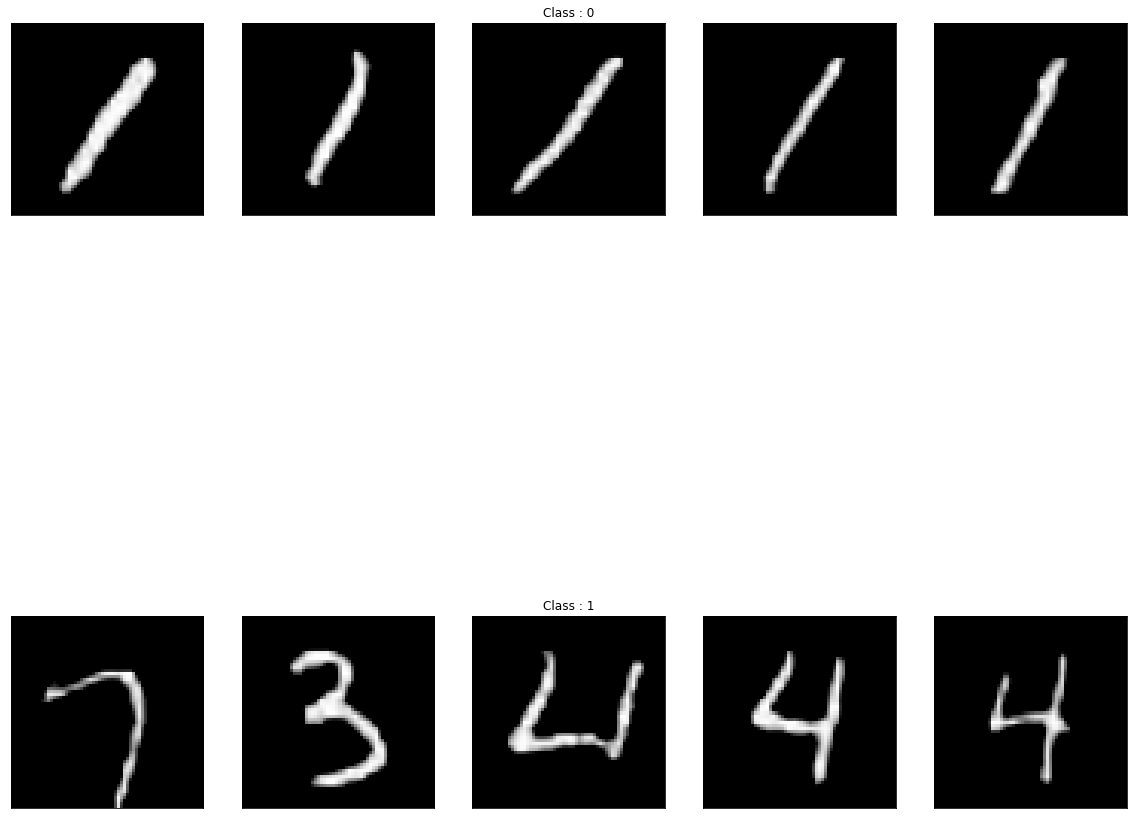

In [11]:
_, axarr = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))

sample_keys = list(test_dataset.data.keys())
# print(sample_keys)
for a in range(2):
    for b in range(5):
        temp_image = test_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [12]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
# create generator model based on resnet50 and unet network
def build_generator_resnet50_unet(input_shape):
    # print(inputs)
    # print("pretained start")
    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_shape)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (256 x 256)
    s2 = resnet50.get_layer("conv1_relu").output        ## (128 x 128)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (64 x 64)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (32 x 32)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (16 x 16)

    """ Decoder """
    x = IMG_H
    d1 = decoder_block(b1, s4, x)                     ## (32 x 32)
    x = x/2
    d2 = decoder_block(d1, s3, x)                     ## (64 x 64)
    x = x/2
    d3 = decoder_block(d2, s2, x)                     ## (128 x 128)
    x = x/2
    d4 = decoder_block(d3, s1, x)                      ## (256 x 256)
    
    """ Output """
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="tanh")(d4)

    model = tf.keras.models.Model(inputs, outputs)

    return model

In [14]:
# create discriminator model
def build_discriminator(inputs):
    f = [2**i for i in range(4)]
    x = inputs
    for i in range(0, 4):
        x = tf.keras.layers.SeparableConvolution2D(f[i] * IMG_H ,kernel_size= (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    
    feature = x
    
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1, activation="tanh")(x)
    
    model = tf.keras.models.Model(inputs, outputs = [feature, output])
    
    return model
    # return x

In [ ]:
def gradient_penalty(discriminator, batch_size, real_images, fake_images):
    """ Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [15]:
input_shape = (IMG_H, IMG_W, IMG_C)
# set input 
inputs = tf.keras.layers.Input(input_shape, name="input_1")
d_model = build_discriminator(inputs)
g_model = build_generator_resnet50_unet(inputs)
d_model.compile()
g_model.compile()

g_optimizer = GCAdam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)
d_optimizer = GCAdam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)

In [16]:
ADV_REG_RATE_LF = 1
REC_REG_RATE_LF = 50
SSIM_REG_RATE_LF = 10
FEAT_REG_RATE_LF = 1

gen_loss_list = []
disc_loss_list = []
iter_list = []
auc_list = []

In [ ]:
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    d_old_vars = d_model.get_weights()
    g_old_vars = g_model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    gen_loss_out = 0.0
    disc_loss_out = 0.0
    for images, labels in mini_dataset:
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # tf.print("Images: ", images)
            reconstructed_images = g_model(images, training=True)
            feature_real, label_real = d_model(images, training=True)
            # print(generated_images.shape)
            feature_fake, label_fake = d_model(reconstructed_images, training=True)

       
            # use wessertein loss
            loss_gen_w = generator_wassertein_loss(label_fake)

            loss_disc_w = discriminator_wassertein_loss(label_real, label_fake)
            
            
            # Loss 2: RECONSTRUCTION loss (L1)
            loss_rec = tf.reduce_mean(mae(images, reconstructed_images))
        
            # Loss 3: SSIM Loss
            loss_ssim =  ssim(images, reconstructed_images)
        
            # Loss 4: FEATURE Loss
#             loss_feat = tf.reduce_mean(mse(real_output, fake_output))
            loss_feat = feat(feature_real, feature_fake)

            gen_loss = tf.reduce_mean( (loss_gen_w * ADV_REG_RATE_LF) + (loss_rec * REC_REG_RATE_LF) + (loss_ssim * SSIM_REG_RATE_LF) + (loss_feat * FEAT_REG_RATE_LF) )
            disc_loss = tf.reduce_mean( (loss_disc_w * ADV_REG_RATE_LF) + (loss_feat * FEAT_REG_RATE_LF) )
#             disc_loss = adv_loss
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, d_model.trainable_variables)
        gradients_of_generator = gen_tape.gradient(gen_loss, g_model.trainable_variables)
        
        gen_loss_out = gen_loss
        disc_loss_out = disc_loss
        
        d_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))
        g_optimizer.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))
        
    
    
     
    d_new_vars = d_model.get_weights()
    g_new_vars = g_model.get_weights()
    
    # Perform SGD for the meta step.
    for var in range(len(d_new_vars)):
        d_new_vars[var] = d_old_vars[var] + (
            (d_new_vars[var] - d_old_vars[var]) * cur_meta_step_size
        )
    
    
    
    for var in range(len(g_new_vars)):
        g_new_vars[var] = g_old_vars[var] + (
            (g_new_vars[var] - g_old_vars[var]) * cur_meta_step_size
        )
    
    
    
    # After the meta-learning step, reload the newly-trained weights into the model.
    g_model.set_weights(g_new_vars)
    d_model.set_weights(d_new_vars)
    # Evaluation loop
    
    if meta_iter % eval_interval == 0:
        
        if meta_iter % 100 == 0:
            
            iter_list = np.append(iter_list, meta_iter)
            gen_loss_list = np.append(gen_loss_list, gen_loss_out)
            disc_loss_list = np.append(disc_loss_list, disc_loss_out)
            
            # range between 0-1
            anomaly_weight = 0.1

            scores_ano = []
            real_label = []

            
            i = 0
            test_ds = test_dataset.get_dataset(1)

            d_old_vars = d_model.get_weights()
            g_old_vars = g_model.get_weights()

            for images, labels in test_ds:
                # print(i)
                i += 1
            
                reconstructed_images = g_model(images, training=False)
                feature_real, label_real  = d_model(images, training=False)
                # print(generated_images.shape)
                feature_fake, label_fake = d_model(reconstructed_images, training=False)
                
                # Loss 2: RECONSTRUCTION loss (L1)
                loss_rec = tf.reduce_mean(mae(images, reconstructed_images))

                loss_feat = feat(feature_real, feature_fake)

                # Loss 3: SSIM Loss
                loss_ssim =  ssim(images, reconstructed_images)

                score = (anomaly_weight * loss_rec) + ((1-anomaly_weight) * loss_feat)

                scores_ano = np.append(scores_ano, score.numpy())
                real_label = np.append(real_label, labels.numpy()[0])
        
            ''' Scale scores vector between [0, 1]'''
            scores_ano = (scores_ano - scores_ano.min())/(scores_ano.max()-scores_ano.min())

            auc_out, _ = roc(real_label, scores_ano, name_model)
            auc_list = np.append(auc_list, auc_out)



#             scores_ano = (scores_ano > threshold).astype(int)
#             # print("real label: ", real_label)
#             # print("anomaly score: ", scores_ano)
#             cm = tf.math.confusion_matrix(labels=real_label, predictions=scores_ano).numpy()
            
#             # TP = cm[1][1]
#             # FP = cm[0][1]
#             # FN = cm[1][0]
#             # TN = cm[0][0]
           

#             diagonal_sum = cm.trace()
#             sum_of_all_elements = cm.sum()

            # print("Accuracy: ", diagonal_sum / sum_of_all_elements )
    #         print("False Alarm Rate: ", FP/(FP+TP))
    #         print("Leakage Rate: ", FN/(FN+TN))
    #         print("precision_score: ",precision_score(real_label, scores_ano))
    # #         print("recall_score: ", recall_score(real_label, scores_ano))
    #         print("recall_score: ", TP/(TP+FN))
    # #         F1 = 2 * (precision * recall) / (precision + recall)
    #         print("F1-Score: ", f1_score(real_label, scores_ano))
            
            print(
                "model saved. batch %d:, AUC=%f, Gen Loss=%f, Disc Loss=%f" % (meta_iter, auc_out, gen_loss_out, disc_loss_out)
            )
            
            # save model's weights
            g_model.save(g_model_path)
            d_model.save(d_model_path)

model saved. batch 0:, AUC=0.001600, Gen Loss=47.614918, Disc Loss=0.312848


/Users/mrcaelumn/YZU/.jupyter_env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
plot_epoch_result(iter_list, gen_loss_list, "Generator_Loss", name_model, "g")
plot_epoch_result(iter_list, disc_loss_list, "Discriminator_Loss", name_model, "r")
plot_epoch_result(iter_list, auc_list, "AUC", name_model, "b")